# TD2

## Calibration de caméra

La calibration est une étape ULTRA importante dans un système d'acquisition. Cela permet notamment de rectifier l'acquisition pour une représentation fidèle de la scène à analyser dans le domaine numérique.

Cet exercice ici est plus un tutoriel de calibration qu'un travail de codage. Vous aurez les fonctions quasi toutes développées, et l'objectif sera d'analyser les actions qui sont faites, comprendre la nature des variables, et ainsi maitriser le processus de calibration. A la fin, vous aurez également un cas d'usage permettrant de saisir l'utilité de la calibration.

Mais d'abord, on va faire un rappel.

---
### Le modèle de caméra trou d’épingle

Le trou d’épingle (pinhole) est utilisé pour modéliser
simplement les caméras. Le modèle utilisé dans le TD est plus complexe puisqu’il est
possible de gérer la non orthogonalité des lignes et colonnes du plan image ainsi que des
distorsions optiques (radiales et tangentielles). Le modèle intègre les paramètres
**intrinsèques** et **extrinsèques**.

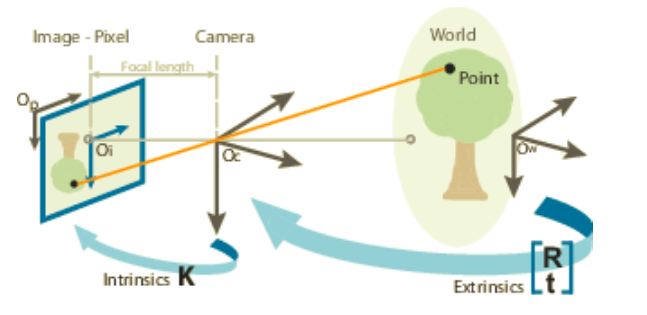

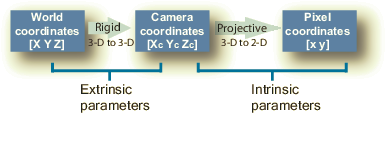

Les paramètres **extrinsèques** sont ceux qui permettent de situer un point du **repère Monde** [$X$,$Y$,$Z$] dans le **repère Caméra** [$X_{C}$,$Y_{C}$,$Z_{C}$]. Cette transition se fait grâce à une matrice des paramètres extrinsèques composée d'une matrice de Rotation $R$ et d'une matrice de translation $t$. La matrice se présente sous la forme suivante :

\begin{equation*}
    \begin{vmatrix}
    r_{xx} & r_{xy} & r_{xz} & t_{x} \\
    r_{yx} & r_{yy} & r_{yz} & t_{y} \\
    r_{zx} & r_{zy} & r_{zz} & t_{z} \\
    0 & 0 & 0 & 1
    \end{vmatrix}
\end{equation*}

La translation est définit par un total de 3 valeurs (1 distance par axe). La rotation est définie également par 3 valeurs (1 angle par axe), permettant de définir les 9 valeurs $r_{ij}$.

Les paramètres **intrinsèques** sont ceux qui permettent de passer un point du **repère Caméra** $[X_{C}$,$Y_{C}$,$Z_{C}$] dans le **repère Numérique** [$u$,$v$] (ce sont les coordonnées des pixels dans la matrice). Cette transition se fait grâce à une matrice des paramètres intrinsèques $K$ construite de la manière suivante :

\begin{equation*}
    K = \begin{vmatrix}
    \alpha_{u} & 0 & u_{0} \\
    0 & \alpha_{v} & v_{0} \\
    0 & 0 & 1
    \end{vmatrix}
\end{equation*}

Les paramètres $\alpha_{u}$ et $\alpha_{v}$ sont des coefficients définis de la manière suivante :

$\alpha_{u} = f.k_{u} ; \alpha_{u} = f.k_{v}$

$f$ correspond à la focale (distance en mm), $k_{u}$ et $k_{v}$ sont des coefficients de conversion pixel -> mm (cela correspond à la taille du pixel en mm).

Les paramètres $u_{0}$ et $v_{0}$ correspondent aux coordonnées du point origine du repère caméra ($X_{C}$=$Y_{C}$=$Z_{C}$=0) dans le repère caméra. C'est très souvent le centre de l'image, mais avec un détail plus précis.

---
### La distorsion

A tous ces jolis coefficients, il faut rajouter les coefficients de distorsion. Ces distorsions sont causées par le modèle de la caméra, créant des images qui ne sont pas conformes à la réalité. On compte 2 types majeurs de distorsion.

La première est la distorsion radiale. D'un point de vue visuel, cette distorsion rend des lignes droites comme incurvées sur l'image. Ce type de distorsion peut être décrit par 3 paramètres ($k_{1}$, $k_{2}$ et $k_{3}$) via la formule suivante :

\begin{equation*}
    x_{distorted} = x (1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6}) \\
    y_{distorted} = y (1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})
\end{equation*}

Dans l'équation ci-dessus, $r$ correspond à la distance euclidienne entre $x_{distorted}$ et $x$. On peut utiliser plus de coefficients ($k_{4}$, $k_{5}$, etc.) pour plus de détails, mais avec 3 coefficients, on a déjà une bonne estimation.

La deuxième est la distorsion tangentielle. Elle se produit parce que l'objectif de prise de vue n'est pas parfaitement aligné parallèlement au plan d'imagerie. Certaines zones de l'image peuvent donc sembler plus proches que prévu. Elle est décrite ici avec 2 paramètres ($p_{1}$ et $p_{2}$) dans la formule suivante :

\begin{equation*}
    x_{distorted} = x + |2p_{1}xy + p_{2}(r^{2} + 2x^{2})| \\
    y_{distorted} = y + |p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy|
\end{equation*}

L'objectif principal de la calibration est donc d'estimer le plus précisement possible ces 5 coefficients de distorsion, afin de rectifier par la suite les images. Pour cela, on va utiliser un modèle d'étalonnage dont on connaît les propriétés.

---
### Acquisition

Pour calibrer la caméra, nous devons d’abord prendre plusieurs images d’une mire
d’étalonnage sous différents angles. Un modèle d’étalonnage typique est un damier
asymétrique, où un côté contient un nombre pair de carrés, à la fois noir et blanc, et l’autre
contient un nombre impair de carrés.
Le motif doit être fixé sur une surface plane. La taille d’un carré doit être mesurée en unités
mondiales, par exemple en millimètres, aussi précisément que possible. Dans la pratique, il
est recommandé d’utiliser 10 à 20 images pour un étalonnage précis.

Ici, on est en salle de TD, sans caméra, donc on vous donne les images (dossier mirecalibration_serie2 à télecharger).

In [ ]:
# Chargement des librairies
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [ ]:
%matplotlib inline

# Chargement des images
path='../images_calibration/'
files = os.listdir(path)
files.append(files.pop(0))

images = []
for file in files:
    images.append(cv2.cvtColor(cv2.imread(path+file,1),cv2.COLOR_BGR2RGB))

# Affichage de la première image
plt.close()
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
plt.show()

Les images chargées, nous allons détecter sur l'image les coins du damier, à savoir l'intersection entre deux carrés noirs. Dans notre exemple, il y en a 48 (6x8). Voici un exemple du traitement sur la première image.

In [ ]:
%matplotlib inline

dim_grid = (8,6)
square_size = 28 

objp = np.zeros((dim_grid[0]*dim_grid[1],3), np.float32)
objp[:,:2] = np.mgrid[0:dim_grid[0],0:dim_grid[1]].T.reshape(-1,2) * square_size

objpoints = [] 
imgpoints = [] 

output = images[0].copy()
gray = cv2.cvtColor(output,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, dim_grid, None)

if ret == True:
    objpoints.append(objp)
    corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    imgpoints.append(corners2)

# Affichage des coins détectés sur l'image
cv2.drawChessboardCorners(output, (dim_grid[0],dim_grid[1]), corners2, ret)
plt.close()
plt.figure(figsize=(10,10))
plt.imshow(output)

Que signifient les variables dim_grid et square_size ?

**_Réponse :_**

Que contiennent les variables objpoints et imgpoints ?

**_Réponse :_**

A quoi sert la fonction cv2.cornerSubPix ?

**_Réponse :_**

On va maintenant effectuer la même opération mais sur toutes les images de calibration

In [ ]:
dim_grid = (8,6)
square_size = 28

objp = np.zeros((dim_grid[0]*dim_grid[1],3), np.float32)
objp[:,:2] = np.mgrid[0:dim_grid[0],0:dim_grid[1]].T.reshape(-1,2) * square_size

objpoints = [] 
imgpoints = [] 

for img in images:
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, dim_grid, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)

---
### Calibration

Les coins de damier sont tous détectés ! L'étape suivante est la calibration de la caméra, à savoir l'estimation des coefficients de distorsion $k_{1}$, $k_{2}$, $k_{3}$, $p_{1}$ et $p_{2}$.

Nous avons besoin pour cela des variables objpoints et imgpoints calculées précedemment. On peut également aider à la calibration en fournissant les paramètres intrinsèques lorsqu'on les connaît. Dans notre cas, on va laisser la fonction estimer ces paramètres.

In [ ]:
var1, var2, var3, var4, var5 = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, 4, None, None) 

A quoi correspond chacune des variables calculées précedemment ?

*N'hésitez pas à aller voir la documentation de la fonction, ça pourrait être utile...*

In [ ]:
# Var 1
print("var1 : {}".format(var1))

**_Réponse :_**

In [ ]:
# Var 2
print("var2 : \n{}".format(var2))

**_Réponse :_**

In [ ]:
# Var 3
print("var3 : \n{}".format(var3))

**_Réponse :_**

In [ ]:
# Var 4
print("Premier élément de var4 brut: \n{}".format(var4[0]))
print("Premier élément de var4 après transformation: \n{}".format(cv2.Rodrigues(var4[0])[0]))
print("Taille de var4 : {}".format(len(var4)))

**_Réponse :_**

In [ ]:
# Var 5
print("Premier élément de var5 : \n{}".format(var5[0]))
print("Taille de var5 : {}".format(len(var5)))

**_Réponse :_**

On va maintenant considérer que nous n'avons pas de distorsion tangentielle ($p_{1}$,$p_{2}$ = 0), et également que le coefficient $k_{3}$ est égal à 0. Il faut donc recalibrer la caméra avec ces nouvelles informations. Effectuez la calibration en fixant ces paramètres à 0 (et regardez la documentation de la fonction surtout !)

In [ ]:
var1, var2, var3, var4, var5 = ... 

Qu'est ce que cela change au niveau des valeurs calculées ? A-t-on des écarts signficatifs sur certains paramètres par rapport à la précédente calibration ?

**_Réponse :_**

On va maintenant visualiser les résultats de la calibration avec une figure 3D, avec notre caméra et la position des échiquiers des différentes images estimées.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib widget

# Plein de fonctions pour l'affichage 3D des résultats de la calibration

def inverse_homogeneoux_matrix(M):
    R = M[0:3, 0:3]
    T = M[0:3, 3]
    M_inv = np.identity(4)
    M_inv[0:3, 0:3] = R.T
    M_inv[0:3, 3] = -(R.T).dot(T)

    return M_inv

def transform_to_matplotlib_frame(cMo, X, inverse=False):
    M = np.identity(4)
    M[1,1] = 0
    M[1,2] = 1
    M[2,1] = -1
    M[2,2] = 0

    if inverse:
        return M.dot(inverse_homogeneoux_matrix(cMo).dot(X))
    else:
        return M.dot(cMo.dot(X))

def create_camera_model(camera_matrix, width, height, scale_focal, draw_frame_axis=False):
    fx = camera_matrix[0,0]
    fy = camera_matrix[1,1]
    focal = 2 / (fx + fy)
    f_scale = scale_focal * focal

    # draw image plane
    X_img_plane = np.ones((4,5))
    X_img_plane[0:3,0] = [-width, height, f_scale]
    X_img_plane[0:3,1] = [width, height, f_scale]
    X_img_plane[0:3,2] = [width, -height, f_scale]
    X_img_plane[0:3,3] = [-width, -height, f_scale]
    X_img_plane[0:3,4] = [-width, height, f_scale]

    ratio1 = 0.66
    ratio2 = 0.66
    width=height
    min_cam = -f_scale/2

    # draw camera
    X_center1 = np.array([[-width*ratio1, -width],
                          [height*ratio1, height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center2 = np.array([[width*ratio1, width],
                          [height*ratio1, height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center3 = np.array([[width*ratio1, width],
                          [-height*ratio1, -height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center4 = np.array([[-width*ratio1, -width],
                          [-height*ratio1, -height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center5 = np.stack([X_center1[:,0],X_center2[:,0]],axis=-1)
    X_center6 = np.stack([X_center2[:,0],X_center3[:,0]],axis=-1)
    X_center7 = np.stack([X_center3[:,0],X_center4[:,0]],axis=-1)
    X_center8 = np.stack([X_center4[:,0],X_center1[:,0]],axis=-1)

    X_center9 = np.stack([X_center5[:,0],X_center5[:,0]],axis=-1)
    X_center9[2,1] = min_cam
    X_center10 = np.stack([X_center6[:,0],X_center6[:,0]],axis=-1)
    X_center10[2,1] = min_cam 
    X_center11 = np.stack([X_center7[:,0],X_center7[:,0]],axis=-1)
    X_center11[2,1] = min_cam
    X_center12 = np.stack([X_center8[:,0],X_center8[:,0]],axis=-1)
    X_center12[2,1] = min_cam

    X_center13 = X_center5.copy()
    X_center13[2,:] = min_cam
    X_center14 = X_center6.copy()
    X_center14[2,:] = min_cam
    X_center15 = X_center7.copy()
    X_center15[2,:] = min_cam
    X_center16 = X_center8.copy()
    X_center16[2,:] = min_cam

    # draw camera frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [f_scale/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, f_scale/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, f_scale/2]

    if draw_frame_axis:
        return [X_img_plane, X_center1, X_center2, X_center3, X_center4,
                X_center5, X_center6, X_center7, X_center8,
                X_center9, X_center10, X_center11, X_center12,
                X_center13, X_center14, X_center15, X_center16, 
                X_frame1, X_frame2, X_frame3]
    else:
        return [X_img_plane, X_center1, X_center2, X_center3, X_center4,
                X_center5, X_center6, X_center7, X_center8,
                X_center9, X_center10, X_center11, X_center12]

def create_board_model(board_width, board_height, square_size, draw_frame_axis=False):
    width = board_width*square_size
    height = board_height*square_size

    # draw calibration board
    X_board = np.ones((4,5))
    #X_board_cam = np.ones((extrinsics.shape[0],4,5))
    X_board[0:3,0] = [0,0,0]
    X_board[0:3,1] = [width,0,0]
    X_board[0:3,2] = [width,height,0]
    X_board[0:3,3] = [0,height,0]
    X_board[0:3,4] = [0,0,0]

    # draw board frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [height/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, height/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, height/2]

    if draw_frame_axis:
        return [X_board, X_frame1, X_frame2, X_frame3]
    else:
        return [X_board]

def draw_camera_boards(ax, camera_matrix, cam_width, cam_height, scale_focal,
                       extrinsics, board_width, board_height, square_size,
                       patternCentric):
    min_values = np.zeros((3,1))
    min_values = np.inf
    max_values = np.zeros((3,1))
    max_values = -np.inf

    if patternCentric:
        X_moving = create_camera_model(camera_matrix, cam_width, cam_height, scale_focal)
        X_static = create_board_model(board_width, board_height, square_size)
        static_colors = ['b' for i in range(len(X_static))]
    else:
        X_static = create_camera_model(camera_matrix, cam_width, cam_height, scale_focal, True)
        X_moving = create_board_model(board_width, board_height, square_size)
        static_colors = ['b' for i in range(len(X_static))]
        static_colors[-3]='k'
        static_colors[-2]='k'
        static_colors[-1]='k'
    cm_subsection = np.linspace(0.0, 1.0, extrinsics.shape[0])
    colors = [ cm.jet(x) for x in cm_subsection]

    
    for i in range(len(X_static)):
        X = np.zeros(X_static[i].shape)
        for j in range(X_static[i].shape[1]):
            X[:,j] = transform_to_matplotlib_frame(np.eye(4), X_static[i][:,j])
        ax.plot3D(X[0,:], X[1,:], X[2,:], color=static_colors[i])
        min_values = np.minimum(min_values, X[0:3,:].min(1))
        max_values = np.maximum(max_values, X[0:3,:].max(1))

    for idx in range(extrinsics.shape[0]):
        R, _ = cv2.Rodrigues(extrinsics[idx,0:3])
        cMo = np.eye(4,4)
        cMo[0:3,0:3] = R
        cMo[0:3,3] = extrinsics[idx,3:6]
        for i in range(len(X_moving)):
            X = np.zeros(X_moving[i].shape)
            for j in range(X_moving[i].shape[1]):
                X[0:4,j] = transform_to_matplotlib_frame(cMo, X_moving[i][0:4,j], patternCentric)
            ax.plot3D(X[0,:], X[1,:], X[2,:], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3,:].min(1))
            max_values = np.maximum(max_values, X[0:3,:].max(1))

    return min_values, max_values

def calibration_figure(dim_grid, # Dimensions de la grille (tuple (h,w))
                       square_size, # Taille des carreaux (en mm)
                       intrinsics, # Matrice des paramètres intrinsèques, de taille 3x3
                       rotations, # Liste des matrices de rotations de taille (3,1). La liste est de taille N (nombre d'images/échiquiers à afficher).
                       translations, # Liste des matrices de translations de taille (3,1). La liste est de taille N (nombre d'images/échiquiers à afficher).
                       indices_boards=None):
    
    board_width,board_height=dim_grid
    extrinsics = np.stack([np.concatenate([a[:,0],b[:,0]]) for a,b in zip(rotations,translations)],axis=-1).T

    if indices_boards is not None:
        extrinsics = extrinsics[indices_boards]

    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    ax.set_aspect("equal")

    cam_width = 32 
    cam_height = 24 
    scale_focal = 80000
    min_values, max_values = draw_camera_boards(ax, intrinsics, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, False)

    X_min,Y_min,Z_min = min_values
    X_max,Y_max,Z_max = max_values
    max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

    mid_x = (X_max+X_min) * 0.5
    mid_y = (Y_max+Y_min) * 0.5
    mid_z = (Z_max+Z_min) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('-y')
    ax.set_title('Extrinsic Parameters Visualization')
    plt.show()


In [ ]:
# A compléter
# Affichage des résultats de calibration en 3D
...

---
### Correction

A partir des coefficients calculés, on va pouvoir maintenant corriger les images acquises, grâce au code suivant

In [ ]:
ret, mtx, dist, rvecs, tvecs = var1, var2, var3, var4, var5
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

corrected_images = [cv2.undistort(i, mtx, dist, None, newcameramtx) for i in images]

x, y, w, h = roi
corrected_images = [c[y:y+h, x:x+w] for c in corrected_images]

A quoi sert la fonction getOptimalNewCameraMatrix ?

**_Réponse :_**

Je vous propose maintenant de visualiser le résultat

In [ ]:
%matplotlib inline
plt.close()
plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
plt.imshow(images[-2])
plt.title("Avant la correction")
plt.subplot(122)
plt.imshow(corrected_images[-2])
plt.title("Après la correction")
plt.show()

La correction vous paraît-elle satisfaisante ?

**_Réponse :_**

---
# Cas pratique

Bon, il est possible qu'à ce stade-là, je ne vous ai pas convaincu de l'intérêt de la calibration. Ok, je relève le défi. On va prendre les deux mêmes images affichées précedemment. Sur chacune des images, on va appliquer un algorithme de traitement d'images pour détecter les lignes (Hough). On pourra ensuite comparer les résultats :D

In [ ]:
# Première étape : Détection de contours via le filtre de Canny
img_a = images[-1].copy()
img_b = corrected_images[-1].copy()

output_a = img_a.copy()
output_b = img_b.copy()

gray_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

canny_a = cv2.Canny(gray_a, 50, 200, None, 3)
canny_b = cv2.Canny(gray_b, 50, 200, None, 3)

plt.close()
plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
plt.imshow(canny_a,'gray')
plt.title("Avant la correction")
plt.subplot(122)
plt.imshow(canny_b,'gray')
plt.title("Après la correction")
plt.show()

In [ ]:
# Deuxième étape : application de Hough pour la détection de lignes
lines_a = cv2.HoughLines(canny_a, 1, np.pi / 180, 150, None, 0, 0)
if lines_a is not None:
    for i in range(0, len(lines_a)):
        rho = lines_a[i][0][0]
        theta = lines_a[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(output_a, pt1, pt2, (255,0,0), 2, cv2.LINE_AA)
        
lines_b = cv2.HoughLines(canny_b, 1, np.pi / 180, 150, None, 0, 0)
if lines_b is not None:
    for i in range(0, len(lines_b)):
        rho = lines_b[i][0][0]
        theta = lines_b[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(output_b, pt1, pt2, (255,0,0), 2, cv2.LINE_AA)
        
# Affichage des résultats
plt.close()
plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
plt.imshow(output_a,'gray')
plt.title("Avant la correction")
plt.subplot(122)
plt.imshow(output_b,'gray')
plt.title("Après la correction")
plt.show()

Alors, convaincu ?

**_Réponse :_**